In [3]:
#!/usr/bin/env python3
import sys
sys.path.append("..")

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from train import *
from visual_functions import *
%matplotlib inline

## ---------------------- load data ----------------------------------------
ins, os, hpr, rn = (72,32,1), 15, (24, 33), 0.08
gen = SynthGen(ins, os, hpr, rn)
x_train, y_train = gen.create_dataset(160)
x_test, y_test = gen.create_dataset(10)

Creating dataset...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 915.33it/s]


Creating dataset...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 964.56it/s]


## Use learning rate schedules for faster convergence

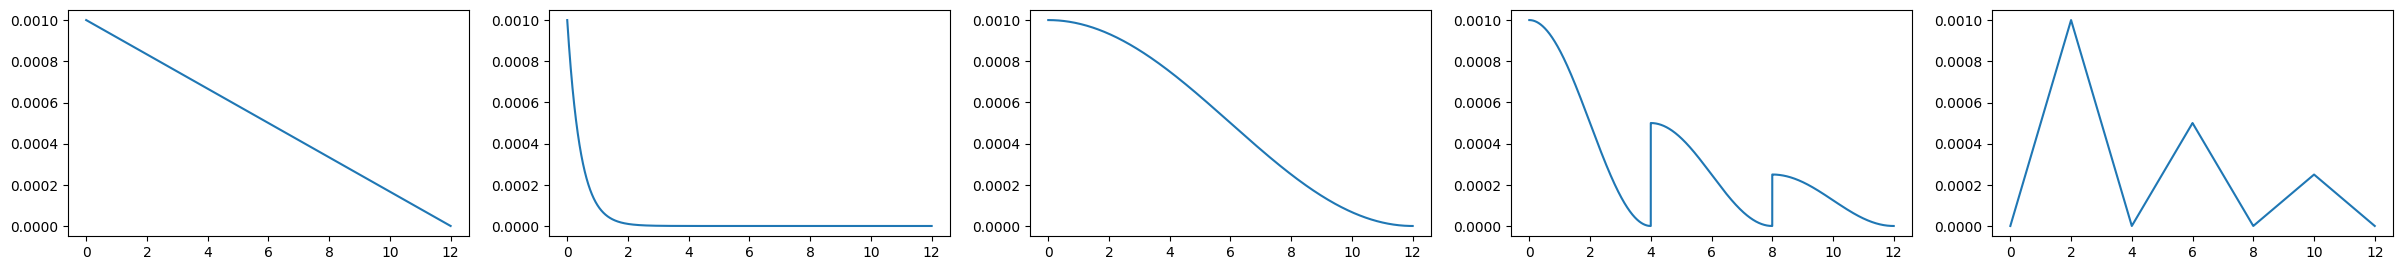

2022-04-13 22:52:49.024188: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-13 22:52:49.169725: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-13 22:52:49.169934: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-13 22:52:49.172347: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [2]:
plt.rcParams['figure.figsize'] = [30, 3]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
epochs = 12
spe = 5000
lin = PolynomialDecay(0.001, epochs*spe, 1e-6)
ed = ExponentialDecay(0.001, spe, 0.1)
cd = CosineDecay(0.001, epochs*spe, alpha=0.0)
cdr = CosineDecayRestarts(0.001,
                          first_decay_steps=4*spe,
                          t_mul=1.0,
                          m_mul=0.5,
                          alpha=1e-6)
tclr = Triangular2CyclicalLearningRate(1e-6, 0.001, 2*spe)



steps = np.arange(0, epochs*spe)
methods = np.array([lin, ed, cd, cdr, tclr])
fig, ax = plt.subplots(1, 5)
for i, m in enumerate(methods):
    ep = np.arange(0, epochs)
    lr = []
    for e in range(epochs):
        steps = np.arange(e*spe, (e+1)*spe)
        lr.append(np.mean(m(steps)))
    #ax[i].scatter(ep, lr)
    
    steps = np.arange(0, epochs*spe)
    ax[i].plot(steps/spe, m(steps))

## Find optimal learning rate range

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 72, 32, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 72, 32, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 32, 16)        2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 36, 16, 16)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 36, 16, 32)        4640      
                                                                 
 conv2d_3 (Conv2D)           (None, 36, 16, 32)        9248      
                                                             

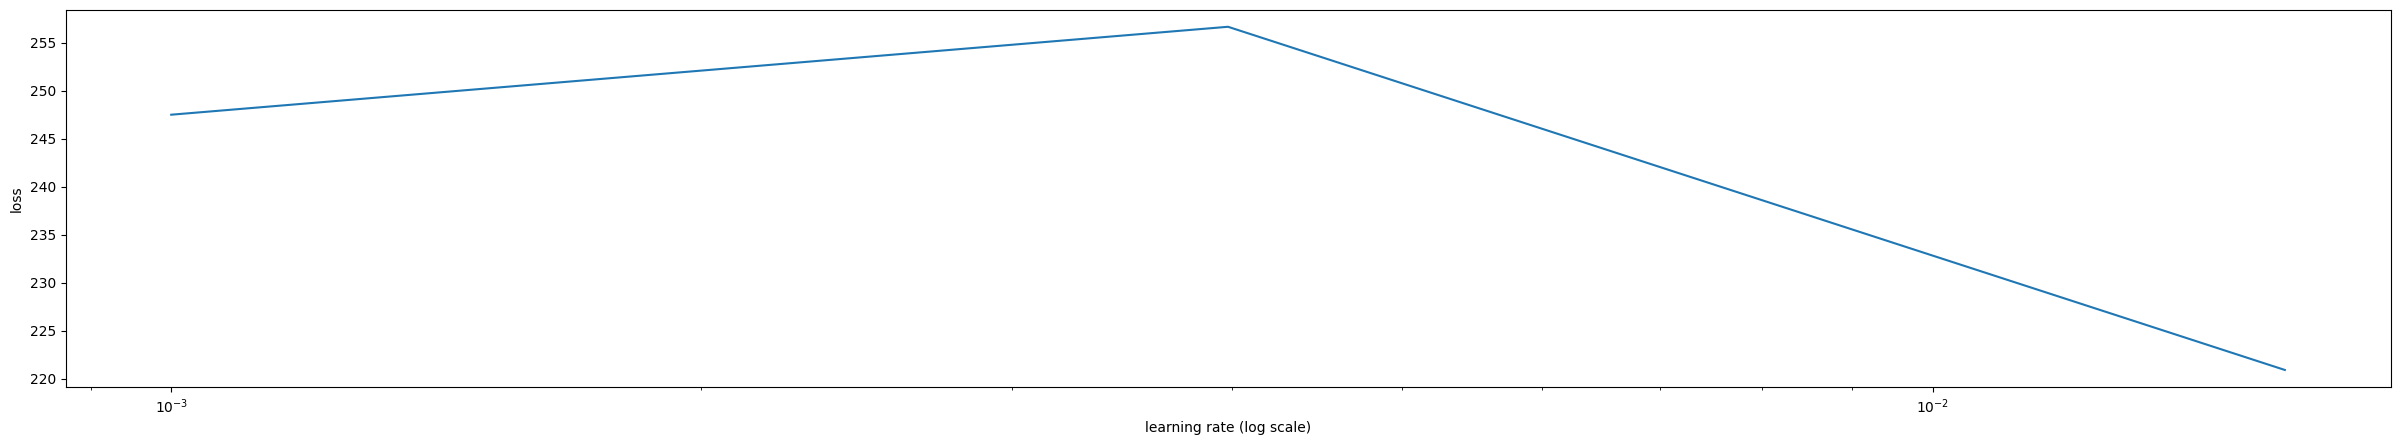

2022-04-13 22:52:53.874019: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8302


In [3]:
from keras_lr_finder import LRFinder
model = plain_net_wo_conf(ins, os)
plt.rcParams['figure.figsize'] = [30, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

#lr = CyclicalLearningRate(config.init_lr, config.max_lr, scale_fn=lambda x: 1/(2.**(x-1)), step_size=3*config.spe)
lr = 0.001
opt= Adam(lr)
model.compile(optimizer=opt, loss="mse", metrics=["accuracy"])

lr_finder = LRFinder(model)
lr_finder.find(x_train, y_train, start_lr=1e-9, end_lr=1, batch_size=32, epochs=3)
lr_finder.plot_loss(n_skip_end=1)
plt.show()

## transform to stepwise decay in order to use it for tmva

In [17]:
nums = [2**n*12 for n in range(10)]
resets = [np.sum(nums[:n]) for n in range(10)]
resets

[0.0, 12, 36, 84, 180, 372, 756, 1524, 3060, 6132]

0,0.0009940548;1,0.000982162;2,0.00097026903;3,0.0009583762;4,0.00094648334;5,0.0009345905;6,0.00092269765;7,0.0009108047;8,0.00089891197;9,0.00088701904;10,0.0008751263;11,0.00086323335;12,0.0008513405;13,0.0008394476;14,0.0008275548;15,0.00081566203;16,0.00080376904;17,0.0007918762;18,0.00077998335;19,0.0007680905;20,0.00075619767;21,0.00074430474;22,0.000732412;23,0.00072051905;24,0.00070862623;25,0.00069673336;26,0.0006848405;27,0.0006729477;28,0.0006610548;29,0.0006491619;30,0.00063726906;31,0.00062537624;32,0.0006134833;33,0.0006015905;34,0.0005896976;35,0.0005778048;36,0.00056591193;37,0.00055401906;38,0.0005421262;39,0.0005302333;40,0.0005183405;41,0.0005064476;42,0.00049455476;43,0.0004826619;44,0.000470769;45,0.00045887622;46,0.00044698335;47,0.0004350905;48,0.00042319766;49,0.00041130476;50,0.00039941192;51,0.00038751905;52,0.0003756262;53,0.00036373333;54,0.00035184048;55,0.00033994764;56,0.00032805477;57,0.00031616192;58,0.00030426908;59,0.00029237618;60,0.00028048333;61,0

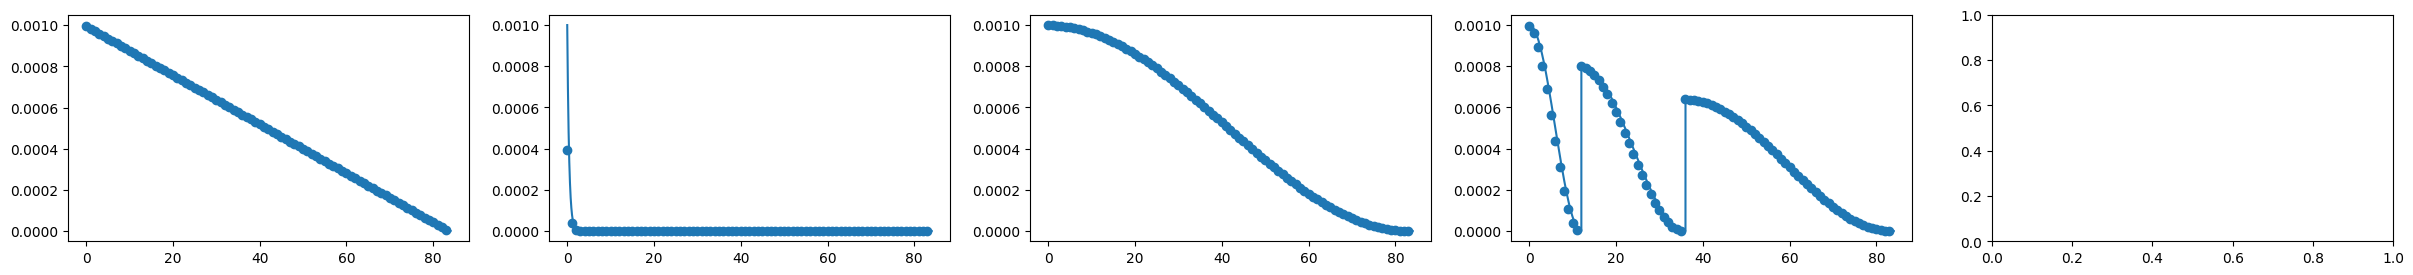

In [26]:
plt.rcParams['figure.figsize'] = [30, 3]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
epochs = 84
spe = 5000
lin = PolynomialDecay(0.001, epochs*spe, 1e-6)
ed = ExponentialDecay(0.001, spe, 0.1)
cd = CosineDecay(0.001, epochs*spe, alpha=0.0)
cdr = CosineDecayRestarts(0.001,
                          first_decay_steps=12*spe,
                          t_mul=2.0,
                          m_mul=0.8,
                          alpha=1e-6)
tclr = Triangular2CyclicalLearningRate(1e-6, 0.001, 2*spe)



steps = np.arange(0, epochs*spe)
methods = np.array([lin, ed, cd, cdr])
fig, ax = plt.subplots(1, 5)
for i, m in enumerate(methods):
    ep = np.arange(0, epochs)
    lr = []
    for e in range(epochs):
        steps = np.arange(e*spe, (e+1)*spe)
        lr.append(np.mean(m(steps)))
    ax[i].scatter(ep, lr)
    steps = np.arange(0, epochs*spe)
    ax[i].plot(steps/spe, m(steps))
    tmva_string = ""
    for e, l in zip(ep, lr):
        tmva_string += str(e) + "," + str(l) + ";"
    print(tmva_string)